In [0]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn import metrics
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import files
uploaded = files.upload()

Saving filtered_ratings_Electronics.csv to filtered_ratings_Electronics.csv


In [0]:
import io
ratingDF=pd.read_csv(io.BytesIO(uploaded['filtered_ratings_Electronics.csv']),names=['userId','productId','ratings','timestamp'])

In [5]:
# ratingDF=pd.read_csv('ratings_Electronics.csv',sep=',',names=['userId','productId','ratings','timestamp'])
ratingDF.head()

,userId,productId,ratings,timestamp
0,AT09WGFUM934H,594481813,3,1377907200
1,AT09WGFUM934H,B00005105L,5,1377475200
2,AT09WGFUM934H,B000068O1M,5,1384905600
3,AT09WGFUM934H,B000068O34,5,1384732800
4,AT09WGFUM934H,B000068O4J,5,1387238400


In [0]:
userGroup=ratingDF['userId'].value_counts()
userGroup=userGroup.reset_index()

In [0]:
userGroup.rename(columns={'index':'userId',
                          'userId':'count'}, 
                 inplace=True)

In [35]:
userGroup.head()

,userId,count
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406


In [0]:
userGroup=userGroup[userGroup['count']>70]

In [0]:
dataFinal=pd.merge(left=ratingDF,right=userGroup, left_on='userId', right_on='userId')

In [38]:
dataFinal.count()

userId       75352
productId    75352
ratings      75352
timestamp    75352
count        75352
dtype: int64

In [39]:
dataFinal['ratings'].value_counts()

5    41780
4    20189
3     7336
2     3161
1     2886
Name: ratings, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1d2947b38>,
      dtype=object)

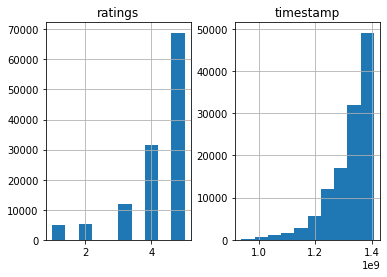

In [40]:
ratingDF.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1c2684a90>,
      dtype=object)

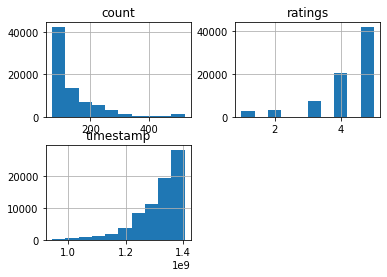

In [41]:
dataFinal.hist()

### Recommending Products based of top mean ratings

In [42]:
dataFinal.groupby('productId')['ratings'].mean().sort_values(ascending = False).head(10)

productId
B00LKG1MC8    5.0
B002IPHA1W    5.0
B002IKKFIC    5.0
B002IKLJU0    5.0
B002IKLJUU    5.0
B002IL30I8    5.0
B002IL8XRQ    5.0
B002IORQ6W    5.0
B002IPH9ZY    5.0
B002IPHA3U    5.0
Name: ratings, dtype: float64

### Recommending Products based on most number of ratings

In [43]:
dataFinal.groupby('productId')['ratings'].count().sort_values(ascending = False).head(10)

productId
B0088CJT4U    131
B003ES5ZUU    102
B002R5AM7C     98
B000N99BBC     98
B00829TIEK     95
B008DWCRQW     91
B007WTAJTO     82
B004CLYEDC     77
B00829THK0     76
B004T9RR6I     70
Name: ratings, dtype: int64

### Lets create a new dataframe with mean rating and rating count

In [44]:
rating_mean_count = pd.DataFrame(dataFinal.groupby('productId')['ratings'].mean()).sort_values(by=['productId'])
rating_mean_count['rating_counts'] = pd.DataFrame(dataFinal.groupby('productId')['ratings'].count()).sort_values(by=['productId'])
rating_mean_count.head()

,ratings,rating_counts
productId,,
1400501466,2.000000,2
1400501776,4.000000,1
1400532620,1.000000,1
1400532655,2.666667,3
1400599997,3.000000,2


#### Lets try to improve the state:

$$weightedrating = \frac{Number of Movie Rating}{(Number of Movie Rating + Minimum Votes)}*Mean rating movie + \\\frac{Minimum Votes}{(Number of Movie Rating + Minimum Votes)}*Mean rating Dataset$$


In [0]:
min_rating = 5

In [0]:
mean_rating_dataset = np.mean(rating_mean_count.ratings.values)

In [0]:
def weighted_rating(rating_mean_count, min_votes, mean_rating_dataset):
    weighted_rating = list()
    V = rating_mean_count.rating_counts.values
    R = rating_mean_count.ratings.values
    for v, r in zip(V, R):
        if v < 5:
            weighted_rating.append(0)
        else:
            weighted_rating.append((v/(v+min_votes))*r + (min_votes/(v+min_votes))*mean_rating_dataset)
    return(weighted_rating)

In [0]:
rating_mean_count['weighted_rating'] = weighted_rating(rating_mean_count, min_rating, mean_rating_dataset)

In [49]:
rating_mean_count.weighted_rating.sort_values(ascending = False).head(10)

productId
B0052SCU8U    4.884881
B003ES5ZUU    4.860616
B001TH7GUU    4.852893
B00BQ4F9ZA    4.830550
B000067RT6    4.829824
B0036Q7MV0    4.824498
B00ISFNSBW    4.822089
B00HZWJGS8    4.813617
B001TH7T2U    4.803438
B0000BZL1P    4.802865
Name: weighted_rating, dtype: float64

In [25]:
pip install scikit-surprise

     |████████████████████████████████| 6.5MB 2.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678215 sha256=1bc2feb4eb70336e01008b87cff024580539487a20d5ab2dbdce82de3c758e13
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from collections import defaultdict
from surprise.model_selection import train_test_split

In [0]:
dataFinal.rename(columns={'productId':'movieId',
                          'userId':'userId',
                          'ratings':'rating'}, 
                 inplace=True)


In [0]:

from surprise import Reader, Dataset
reader = Reader()
data = Dataset.load_from_df(dataFinal[['userId', 'movieId', 'rating']], reader)

In [0]:
trainset, testset = train_test_split(data, test_size=0.3)

In [62]:

np.shape(testset)

(22606, 3)

In [60]:
algo = SVD()
algo.fit(trainset)

In [0]:
testset = trainset.build_anti_testset()

In [0]:
predictions = algo.test(testset)

In [0]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [68]:
# get RMSE
print("SVD Model : Test Set")
accuracy.rmse(predictions, verbose=True)

SVD Model : Test Set
RMSE: 0.3936


0.3936363803058609

In [69]:
print("SVD Model : Test Set")
accuracy.mae(predictions, verbose=True)

SVD Model : Test Set
MAE:  0.3035


0.3035399816956964

In [70]:
get_top_n(predictions,5)

defaultdict(list,
            {'A100UD67AHFODS': [('B000F7QRTG', 5),
              ('B003ES5ZUU', 5),
              ('B00BQ4F9ZA', 5),
              ('B003CFATT2', 5),
              ('B00CD8ADKO', 5)],
             'A100WO06OQR8BQ': [('B0052SCU8U', 4.914105233344484),
              ('B006EKIQYM', 4.76172271148641),
              ('B0007Y791C', 4.674949755983786),
              ('B002WE4HE2', 4.597334355920173),
              ('B000J2GUS0', 4.596354604663066)],
             'A105TOJ6LTVMBG': [('B006W8U2MU', 4.628750916819939),
              ('B005ES0YYA', 4.591678818632575),
              ('B00HZWJGS8', 4.588236119134939),
              ('B00D6XW62I', 4.5646022561276345),
              ('B001DJ64D4', 4.554043580328358)],
             'A10NMELR4KX0J6': [('B0034CL2ZI', 4.691050295269951),
              ('B001342KM8', 4.6885196690551245),
              ('B00077AA5Q', 4.63260556471955),
              ('B000EOMXM0', 4.595662264341996),
              ('B003ES5ZUU', 4.590960205559069)],
      

As we can see the collaborative SVD filtering uses matrix factorization which is complex but gives better results to user than popularity based recommender systems (PRS) as PRS is based largly based on mean rating ,if we have skewed data result can vary hugly.